<a href="https://colab.research.google.com/github/aditya-saurabh/classification/blob/master/Cats_and_Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#---------------------------------------
# Cats and dog classification
#---------------------------------------

#-------------------------------------------------------------------
# Dataset: kaggle competition, dataset by microsoft
# Dataset contains 25,000 coloured, labelled images of cats and dogs
#-------------------------------------------------------------------

In [0]:
#importing libraries

import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from shutil import copyfile

In [2]:
#importing the dataset in zipped format

!wget --no-check-certificate \
    https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip \
    -O /tmp/images.zip



--2020-05-23 12:38:29--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.76.192.41, 2600:1407:a800:194::e59, 2600:1407:a800:19e::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.76.192.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/images.zip’

/tmp/images.zip     100%[===================>] 786.68M  83.0MB/s    in 9.6s    

2020-05-23 12:38:39 (82.2 MB/s) - ‘/tmp/images.zip’ saved [824894548/824894548]



In [0]:
# unzipping the dataset and storing it in '/tmp' folder in the virtual machine

local = '/tmp/images.zip'
zip_ref = zipfile.ZipFile(local, mode='r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# making the required directories

base_dir = '/tmp/PetImages'

TRAIN_DIR = os.path.join(base_dir, 'training')
VALIDATION_DIR = os.path.join(base_dir, 'validation')

TRAIN_DIR_CATS = os.path.join(TRAIN_DIR, 'cats')
TRAIN_DIR_DOGS = os.path.join(TRAIN_DIR, 'dogs')

VALIDATION_DIR_CATS = os.path.join(VALIDATION_DIR, 'cats')
VALIDATION_DIR_DOGS = os.path.join(VALIDATION_DIR, 'dogs')

os.mkdir(TRAIN_DIR)
os.mkdir(VALIDATION_DIR)
os.mkdir(TRAIN_DIR_CATS)
os.mkdir(TRAIN_DIR_DOGS)
os.mkdir(VALIDATION_DIR_CATS)
os.mkdir(VALIDATION_DIR_DOGS)

In [0]:
# function for making the required split for train, validation sets

def train_test_split (SOURCE, DESTINATION, PET, SPLIT_SIZE = 0.9):

  fn = os.listdir(SOURCE)
  train_fn = random.sample(fn, int(len(fn)*SPLIT_SIZE))

  for name in fn:
    src = ''
    src = os.path.join(SOURCE, name)
    dst = ''
    
    if os.path.getsize(src) > 0:
      if name in train_fn:
        dst = os.path.join(DESTINATION, 'training')
        dst = os.path.join(dst, PET)
        dst = os.path.join(dst, name)
        copyfile(src,dst)
      else:
        dst = os.path.join(DESTINATION, 'validation')
        dst = os.path.join(dst, PET)
        dst = os.path.join(dst, name)
        copyfile(src, dst)

In [6]:
# splitting the image data
SRC_CAT = '/tmp/PetImages/Cat'
SRC_DOG = '/tmp/PetImages/Dog'
DST = '/tmp/PetImages'

# splitting for cat data
train_test_split(SRC_CAT, DST, 'cats')

# splitting for dog data
train_test_split(SRC_DOG, DST, 'dogs')

print(len(os.listdir('/tmp/PetImages/training/cats')))
print(len(os.listdir('/tmp/PetImages/training/dogs')))
print(len(os.listdir('/tmp/PetImages/validation/cats')))
print(len(os.listdir('/tmp/PetImages/validation/dogs')))

11249
11249
1251
1251


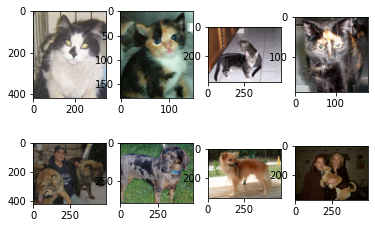

In [102]:
#----------------------------------
# Plotting images from training set
# ---------------------------------

%matplotlib inline
import matplotlib.image as mpimg

fn_cats = random.sample(os.listdir(TRAIN_DIR_CATS), 4) 
fn_dogs = random.sample(os.listdir(TRAIN_DIR_DOGS), 4)

fig, ax = plt.subplots(nrows=2, ncols=4)

i = 0
for rows in ax:
  for cols in rows:
    if i<4:
      path = os.path.join(TRAIN_DIR_CATS, fn_cats[i])
      img = mpimg.imread(path)
      cols.imshow(img)
      i = i+1
    else:
      path = os.path.join(TRAIN_DIR_DOGS, fn_dogs[i-4])
      img = mpimg.imread(path)
      cols.imshow(img) 
      i = i+1

In [67]:
# data augmentation and defining image generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale=1.0/255,
                                      horizontal_flip=True, zoom_range=0.2, rotation_range=20,
                                      shear_range=0.2, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

training_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224), 
                                                          class_mode='binary', batch_size = 50)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224), 
                                                          class_mode='binary')

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [14]:
print(VALIDATION_DIR)

/tmp/PetImages/validation


In [0]:
# VGG-13 layer network network

model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
                    tf.keras.layers.MaxPooling2D(2),
                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                    tf.keras.layers.MaxPooling2D(2),
                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                    tf.keras.layers.MaxPooling2D(2),
                    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                    tf.keras.layers.MaxPooling2D(2),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 256)      

In [0]:
# defining the callback function

class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end (self, epoch, logs={}):
    if logs.get('accuracy') > 0.99:
      print('\n Reached 99 percent accuracy, stopping training')
      self.stop_training = True

In [18]:
history = model.fit_generator(generator=training_generator, callbacks=[myCallbacks()], validation_data=validation_generator,
                              epochs=20)

Epoch 1/20
202/450 [============>.................] - ETA: 1:49 - loss: 0.6888 - accuracy: 0.5318

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

450/450 [==============================] - 209s 464ms/step - loss: 0.6624 - accuracy: 0.5859 - val_loss: 0.5791 - val_accuracy: 0.7038
Epoch 2/20
450/450 [==============================] - 207s 461ms/step - loss: 0.5209 - accuracy: 0.7439 - val_loss: 0.4917 - val_accuracy: 0.7642
Epoch 3/20
450/450 [==============================] - 206s 458ms/step - loss: 0.4427 - accuracy: 0.7933 - val_loss: 0.4069 - val_accuracy: 0.8141
Epoch 4/20
450/450 [==============================] - 208s 461ms/step - loss: 0.3987 - accuracy: 0.8198 - val_loss: 0.3676 - val_accuracy: 0.8361
Epoch 5/20
450/450 [==============================] - 208s 463ms/step - loss: 0.3534 - accuracy: 0.8421 - val_loss: 0.3808 - val_accuracy: 0.8309
Epoch 6/20
450/450 [==============================] - 208s 462ms/step - loss: 0.3210 - accuracy: 0.8595 - val_loss: 0.2924 - val_accuracy: 0.8737
Epoch 7/20
450/450 [==============================] - 207s 460ms/step - loss: 0.2988 - accuracy: 0.8711 - val_loss: 0.2768 - val_accura

In [0]:
# saving the model
history.save('my_model.h5')

Text(0.5, 1.0, 'Training and validation loss')

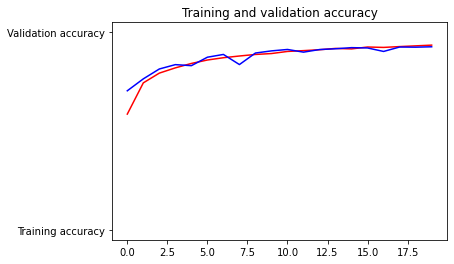

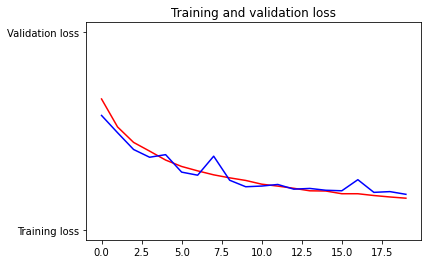

In [19]:
# PLOT LOSS AND ACCURACY

%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot validation and training accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, 'r', 'Training accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

#--------------------------------------------------
# Plot validation and training loss per epoch
#--------------------------------------------------

plt.plot(epochs, loss, 'r', 'Training loss')
plt.plot(epochs, val_loss, 'b', 'Validation loss')
plt.title('Training and validation loss')

In [85]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-2143332_1920.jpg to cat-2143332_1920 (4).jpg


ValueError: ignored

In [0]:
#---------------------------------------------------
# Transfer Learning
#---------------------------------------------------




#---------------------------------------------------
# Implementing the Inception V3 model
#---------------------------------------------------

In [103]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(include_top = False, weights='imagenet', input_shape=(224,224,3))

for layers in pre_trained_model.layers:
  layers.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_572 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 111, 111, 32) 96          conv2d_572[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 111, 111, 32) 0           batch_normalization_564[0][0]    
_______________________________________________________________________________________

In [0]:
last_layer = pre_trained_model.get_layer('mixed4')
last_layer_out = last_layer.output

In [105]:
x = tf.keras.layers.Flatten()(last_layer_out)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_572 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 111, 111, 32) 96          conv2d_572[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 111, 111, 32) 0           batch_normalization_564[0][0]    
____________________________________________________________________________________________

In [0]:
history_inception = model.fit_generator(training_generator, callbacks=[myCallbacks()], 
                                        validation_data=validation_generator, epochs=2)

Epoch 1/2
125/450 [=======>......................] - ETA: 3:50 - loss: 1.3240 - accuracy: 0.7981

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

450/450 [==============================] - 337s 749ms/step - loss: 0.5345 - accuracy: 0.8737 - val_loss: 0.1993 - val_accuracy: 0.9197
Epoch 2/2
250/450 [===============>..............] - ETA: 2:26 - loss: 0.1907 - accuracy: 0.9211

Text(0.5, 1.0, 'Training and validation loss')

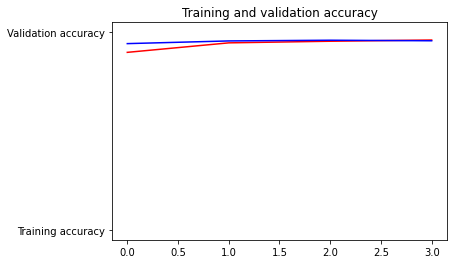

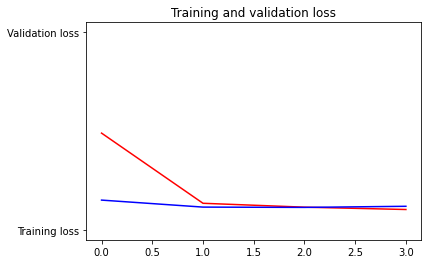

In [72]:
# PLOT LOSS AND ACCURACY

%matplotlib inline
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot validation and training accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, 'r', 'Training accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

#--------------------------------------------------
# Plot validation and training loss per epoch
#--------------------------------------------------

plt.plot(epochs, loss, 'r', 'Training loss')
plt.plot(epochs, val_loss, 'b', 'Validation loss')
plt.title('Training and validation loss')

In [96]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dog-1020790_1920.jpg to dog-1020790_1920 (2).jpg
[1.]
dog-1020790_1920.jpg is a dog


In [97]:
print(classes[0])

[1.]
